In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


# BI/RETURN CORRELATION

In [2]:
import os


def read_orderbook_df(file_path: str) -> pd.DataFrame:
    df = pd.read_csv(file_path, sep='\t')
    df['MidPrice'] = (df["AskPrice1"]+df["BidPrice1"])/2
    df['Return'] = (-df["MidPrice"]+df["MidPrice"].shift(-1)) / df["MidPrice"]

    pbid = df["BidPrice1"] - df[f"BidPrice15"]
    pask = df[f"AskPrice15"] - df["AskPrice1"]
    df["BaseImbalance"] = (pbid-pask)/(pbid+pask)

    df=df.dropna(subset=['Return', 'BaseImbalance'])
    df = df[df['Return'] != 0]
    df = df[['Timestamp', 'BaseImbalance', 'Return']]
    df['Diff'] = df['Timestamp'].diff()

    return df

def read_best_densities_df(file_path: str) -> pd.DataFrame:
    return pd.read_csv(file_path)

def get_subsetted_orderbook_df(orderbook_df: pd.DataFrame, simulation_time_seconds: int) -> pd.DataFrame:
    simulation_time_milliseconds = simulation_time_seconds * 1000
    training_start_time = simulation_time_milliseconds - (1800*1000)
    simulation_end_time = simulation_time_milliseconds + (120*1000)
    return orderbook_df[
        (orderbook_df['Timestamp'] >= training_start_time)
        & (orderbook_df['Timestamp'] <= simulation_end_time)
    ]

def get_all_df(best_densities_df: pd.DataFrame, orderbook_dir_path: str) -> pd.DataFrame:
    dfs = []
    for i in range(len(best_densities_df)):
        timestamp_filename = str(best_densities_df.iloc[i]['timestamp'])
        simulation_time_seconds = best_densities_df.iloc[i]['timestamp_density']
        
        orderbook_filename = [f for f in os.listdir(orderbook_dir_path)
                              if timestamp_filename in f][0]
        
        orderbook_df = read_orderbook_df(
            os.path.join(orderbook_dir_path,orderbook_filename))
        subsetted_orderbook_df = get_subsetted_orderbook_df(orderbook_df, simulation_time_seconds)
        dfs.append(subsetted_orderbook_df)

    return pd.concat(dfs)

def get_decile_mean_df(metrics_df: pd.DataFrame) -> pd.DataFrame:
    metrics_df['decile'] = pd.qcut(metrics_df['BaseImbalance'], q=10, labels=False, precision=0)
    average_values = metrics_df.groupby('decile')[['BaseImbalance', 'Return']].mean()
    return average_values


In [16]:
best_density_df = read_best_densities_df('data/best_densities_full.csv')
orderbook_df = get_all_df(best_density_df, '/home/davide/Desktop/phd/bitfinex-api-py/data/orderbook_changes')
orderbook_df['Diff'] = (orderbook_df['Diff']).abs() / 1000

orderbook_df.head()

,Timestamp,BaseImbalance,Return,Diff
1466,1705074344673,-0.057143,-0.000067,0.692
1468,1705074345102,0.000000,0.000034,0.429
1469,1705074345319,0.000000,-0.000011,0.217
1470,1705074345535,-0.016393,0.000045,0.216
1483,1705074348163,-0.058824,0.000381,2.628


In [22]:
orderbook_df[['BaseImbalance', 'Return']].corr()

,BaseImbalance,Return
BaseImbalance,1.00000,-0.27587
Return,-0.27587,1.00000


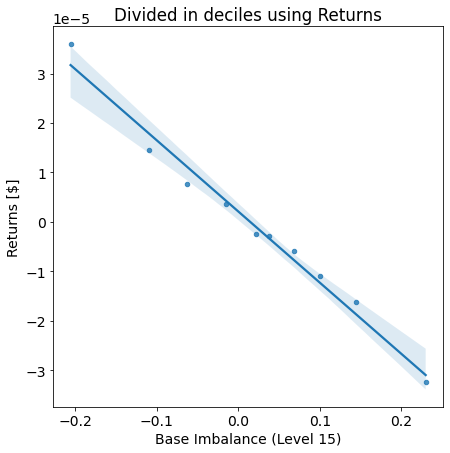

In [20]:
decile_df = get_decile_mean_df(orderbook_df)
# Select two columns for the scatterplot
x_column = 'BaseImbalance'
y_column = 'Return'

# increase plot size
plt.figure(figsize=(7, 7))
# increase labels size
plt.rcParams.update({'font.size': 14})

# Create a scatterplot with regression line using Seaborn
sns.regplot(data=decile_df, x=x_column, y=y_column, scatter_kws={'s': 20})
plt.title(f'Divided in deciles using Returns')
plt.xlabel('Base Imbalance (Level 15)')
plt.ylabel('Returns [$]')
plt.show()

In [21]:
decile_df.corr()

,BaseImbalance,Return
BaseImbalance,1.000000,-0.990283
Return,-0.990283,1.000000


In [17]:
usdt_df = pd.read_csv('/home/davide/Desktop/phd/BITFINEX_SPOT_USDT_USD.csv', sep=';')
usdt_df['MidPrice'] = (usdt_df["asks[0].price"]+usdt_df["bids[0].price"])/2
usdt_df['Return'] = (-usdt_df["MidPrice"]+usdt_df["MidPrice"].shift(-1)) / usdt_df["MidPrice"]
usdt_df = usdt_df[usdt_df['Return'] != 0]
usdt_df['time_exchange'] = pd.to_datetime(usdt_df['time_exchange'], format='%H:%M:%S.%f')

# Calculate total milliseconds and create 'Timestamp' column
usdt_df['Timestamp'] = usdt_df['time_exchange'].dt.hour * 3600000 + usdt_df['time_exchange'].dt.minute * 60000 + usdt_df['time_exchange'].dt.second * 1000 + usdt_df['time_exchange'].dt.microsecond / 1000
usdt_df['Diff'] = usdt_df['Timestamp'].diff()
usdt_df['Diff'] = (usdt_df['Diff']).abs() / 1000

usdt_df.head()

,time_exchange,time_coinapi,asks[0].price,asks[0].size,bids[0].price,bids[0].size,asks[1].price,asks[1].size,bids[1].price,bids[1].size,...,bids[48].price,bids[48].size,asks[49].price,asks[49].size,bids[49].price,bids[49].size,MidPrice,Return,Timestamp,Diff
3,1900-01-01 00:00:14.366688200,00:00:14.3666882,1.012,23982.982590,1.0118,39508.944704,1.0123,10.35267,1.0115,5817.791828,...,1.0033,2491.421600,1.0338,110.00,1.0032,23648.286768,1.01190,0.000049,14366.688,NaN
139,1900-01-01 00:04:04.848756100,00:04:04.8487561,1.012,13476.768275,1.0119,10000.000000,1.0123,10.35267,1.0118,39508.944704,...,1.0037,2425.452057,1.0360,50000.00,1.0036,1602.059566,1.01195,-0.000049,244848.756,230.482068
156,1900-01-01 00:04:35.223321800,00:04:35.2233218,1.012,13476.768275,1.0118,39508.944704,1.0123,10.35267,1.0116,4000.000000,...,1.0037,2425.452057,1.0350,119.76,1.0036,1602.059566,1.01190,0.000049,275223.321,30.374565
159,1900-01-01 00:04:42.317190300,00:04:42.3171903,1.012,13476.768275,1.0119,11323.162713,1.0123,10.35267,1.0118,39508.944704,...,1.0037,2425.452057,1.0360,50000.00,1.0036,1602.059566,1.01195,-0.000049,282317.190,7.093869
160,1900-01-01 00:04:43.338182100,00:04:43.3381821,1.012,13476.768275,1.0118,39508.944704,1.0123,10.35267,1.0116,4000.000000,...,1.0036,1602.059566,1.0360,50000.00,1.0035,30020.020020,1.01190,0.000049,283338.182,1.020992


Text(0, 0.5, 'Event duration [s]')

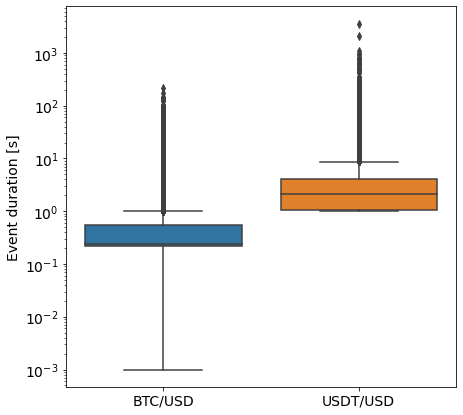

In [19]:

btc_df_diff = orderbook_df[['Diff']].copy()
btc_df_diff['Pair'] = 'BTC/USD'
usdt_df_diff = usdt_df[['Diff']].copy()
usdt_df_diff['Pair'] = 'USDT/USD'

diff_df = pd.concat([btc_df_diff, usdt_df_diff])


# boxplot of the differences with log scale

plt.figure(figsize=(7, 7))
plt.rcParams.update({'font.size': 14})
sns.boxplot(data=diff_df, x='Pair', y='Diff')
plt.yscale('log')
plt.xlabel('')
plt.ylabel('Event duration [s]')

# INTENSITY

In [2]:
prediction_df = pd.read_csv('data/hawkes_15_right_predictions.csv')
prediction_df[prediction_df['ErrorPrediction'] < 0.05]

,Timestamp,BaseImbalance,Return,LastEventTimestampNotScaled,NearestEventTimestampNotScaled,RealNextEventTimestampNotScaled,TimestampFile,TimestampDensity,Submethod,Method,SubmethodParam,BiLevel,ErrorPrediction,IsNextTimestampNearPrediction
24,1903.814,0.000000,0.000035,1902.635,1903.848,1903.848,1706974616234,1706973066,hawkes_15,hawkes,15,15,0.034,True
31,1919.314,0.000000,0.000012,1911.686,1919.314,1919.314,1706974616234,1706973066,hawkes_15,hawkes,15,15,0.000,True
33,1815.628,0.157895,-0.000075,1814.660,1815.583,1815.583,1706086819658,1706081931,hawkes_15,hawkes,15,15,0.045,True
56,1899.431,-0.027027,0.000012,1898.560,1899.469,1899.469,1706086819658,1706081931,hawkes_15,hawkes,15,15,0.038,True
64,1918.699,-0.030303,0.000012,1915.948,1918.656,1918.656,1706086819658,1706081931,hawkes_15,hawkes,15,15,0.043,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1612,1911.330,-0.157895,0.000012,1910.860,1911.298,1911.298,1705356920082,1705353794,hawkes_15,hawkes,15,15,0.032,True
1616,1802.710,-0.085714,-0.000023,1801.813,1802.730,1802.730,1707216507382,1707216002,hawkes_15,hawkes,15,15,0.020,True
1620,1816.037,-0.024390,0.000070,1815.578,1816.011,1816.011,1707216507382,1707216002,hawkes_15,hawkes,15,15,0.026,True
1634,1879.309,0.128205,0.000023,1878.807,1879.259,1879.259,1707216507382,1707216002,hawkes_15,hawkes,15,15,0.050,True


In [23]:
orderbook_df = pd.read_csv('/home/davide/Desktop/phd/bitfinex-api-py/data/orderbook_changes/orderbook_changes_1706974616234.tsv', sep='\t')
orderbook_df['ShiftedTimestamp'] = (orderbook_df['Timestamp'] / 1000) - 1706973578 + 1800
orderbook_df.tail()

,AskPrice1,AskSize1,AskPrice2,AskSize2,AskPrice3,AskSize3,AskPrice4,AskSize4,AskPrice5,AskSize5,...,BidPrice22,BidSize22,BidPrice23,BidSize23,BidPrice24,BidSize24,BidPrice25,BidSize25,Timestamp,ShiftedTimestamp
32344,43051,0.112,43061,0.094,43064,0.1556,43067,0.045180,43068,0.464383,...,43024.0,0.272330,43023.0,0.02783,43021.0,0.023183,43020.0,0.150684,1706974615428,2837.428
32345,43051,0.112,43061,0.094,43064,0.1556,43067,0.045180,43068,0.464383,...,43025.0,0.162883,43024.0,0.27233,43023.0,0.027830,43021.0,0.023183,1706974615621,2837.621
32346,43051,0.112,43061,0.094,43064,0.1556,43067,0.045180,43068,0.464383,...,43024.0,0.272330,43023.0,0.02783,43021.0,0.023183,43020.0,0.150684,1706974615828,2837.828
32347,43051,0.112,43061,0.094,43064,0.1556,43068,0.515383,43069,0.073183,...,43024.0,0.272330,43023.0,0.02783,43021.0,0.023183,43020.0,0.150684,1706974616032,2838.032
32348,43051,0.112,43061,0.094,43064,0.1556,43068,0.515383,43069,0.073183,...,43024.0,0.272330,43023.0,0.02783,43021.0,0.023183,43020.0,0.150684,1706974616234,2838.234


In [24]:
orderbook_df[orderbook_df['ShiftedTimestamp'] > 1903]

,AskPrice1,AskSize1,AskPrice2,AskSize2,AskPrice3,AskSize3,AskPrice4,AskSize4,AskPrice5,AskSize5,...,BidPrice22,BidSize22,BidPrice23,BidSize23,BidPrice24,BidSize24,BidPrice25,BidSize25,Timestamp,ShiftedTimestamp
27744,43016,0.122818,43020,0.1032,43021,0.0252,43024,0.025200,43030,0.464792,...,42990.0,0.187135,42987.0,0.006825,42986.0,0.023183,42983.0,0.024156,1706973681092,1903.092
27745,43016,0.122818,43020,0.1032,43021,0.0252,43024,0.025200,43030,0.487975,...,42987.0,0.006825,42986.0,0.023183,42983.0,0.024156,42982.0,0.023183,1706973681296,1903.296
27746,43016,0.122818,43020,0.1032,43021,0.0252,43024,0.025200,43028,0.464815,...,42986.0,0.023183,42983.0,0.024156,42982.0,0.023183,42981.0,0.300827,1706973681502,1903.502
27747,43016,0.122818,43020,0.1032,43021,0.0252,43024,0.025200,43028,0.464815,...,42987.0,0.006825,42986.0,0.023183,42983.0,0.024156,42982.0,0.023183,1706973681688,1903.688
27748,43016,0.122818,43020,0.1032,43021,0.0252,43024,0.025200,43028,0.464815,...,42987.0,0.006825,42986.0,0.023183,42983.0,0.024156,42982.0,0.023183,1706973681888,1903.888
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32344,43051,0.112000,43061,0.0940,43064,0.1556,43067,0.045180,43068,0.464383,...,43024.0,0.272330,43023.0,0.027830,43021.0,0.023183,43020.0,0.150684,1706974615428,2837.428
32345,43051,0.112000,43061,0.0940,43064,0.1556,43067,0.045180,43068,0.464383,...,43025.0,0.162883,43024.0,0.272330,43023.0,0.027830,43021.0,0.023183,1706974615621,2837.621
32346,43051,0.112000,43061,0.0940,43064,0.1556,43067,0.045180,43068,0.464383,...,43024.0,0.272330,43023.0,0.027830,43021.0,0.023183,43020.0,0.150684,1706974615828,2837.828
32347,43051,0.112000,43061,0.0940,43064,0.1556,43068,0.515383,43069,0.073183,...,43024.0,0.272330,43023.0,0.027830,43021.0,0.023183,43020.0,0.150684,1706974616032,2838.032


In [25]:
attack_times_training = orderbook_df[(orderbook_df['ShiftedTimestamp'] > 0)
                                     & (orderbook_df['ShiftedTimestamp'] < 1800)]['ShiftedTimestamp'].values
warm_up_times = orderbook_df[(orderbook_df['ShiftedTimestamp'] > 1753)
                                & (orderbook_df['ShiftedTimestamp'] < 1903.848)]['ShiftedTimestamp'].values
real_times = orderbook_df[(orderbook_df['ShiftedTimestamp'] > 1753848)
                          & (orderbook_df['ShiftedTimestamp'] <= 1906)]['ShiftedTimestamp'].values

--------------------------------------------------
Launching simulation using SimuHawkesExpKernels...
Done simulating using SimuHawkesExpKernels in 2.86e-03 seconds.
--------------------------------------------------
Launching simulation using SimuHawkesExpKernels...
Done simulating using SimuHawkesExpKernels in 7.14e-04 seconds.
--------------------------------------------------
Launching simulation using SimuHawkesExpKernels...
Done simulating using SimuHawkesExpKernels in 6.29e-03 seconds.
--------------------------------------------------
Launching simulation using SimuHawkesExpKernels...
Done simulating using SimuHawkesExpKernels in 4.63e-04 seconds.


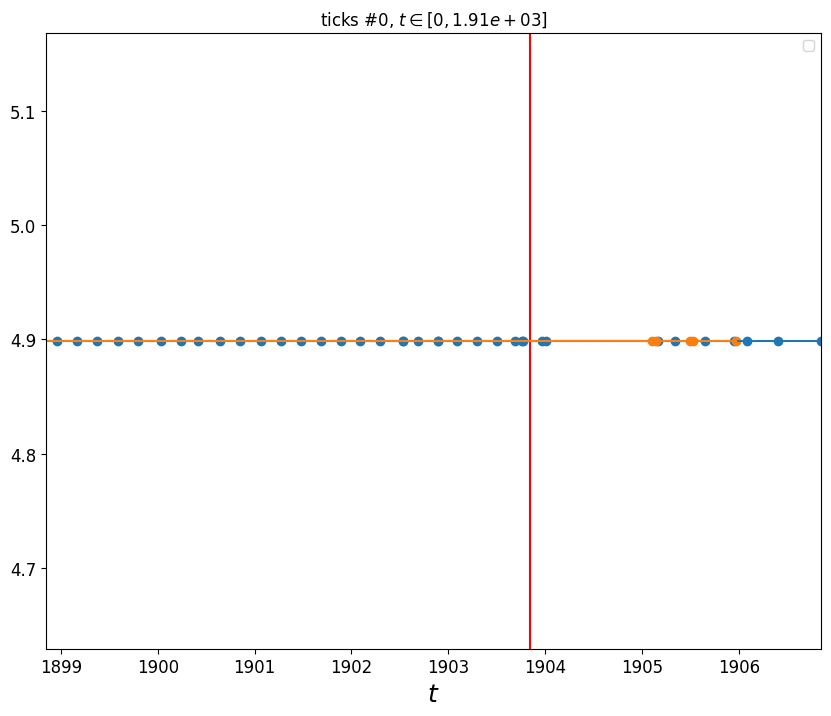

In [27]:
decays = 0.7435045015005002
end_time = 1906
hawkes = hk.HawkesExpKern(decays=decays)
hawkes.fit([attack_times_training])

baseline = hawkes.baseline
adjacency = hawkes.adjacency
abb=baseline[0]
baa= [np.array([decays])]
caa=np.array([[adjacency[0,0]]])

# Code 1
hawkes1 = SimuHawkesExpKernels(adjacency=caa, decays=baa, baseline=[abb], end_time=1903, seed=1039)
simu1 = hawkes1
hawkes1.simulate()
simu1.track_intensity(1)
simu1.set_timestamps([warm_up_times], 1903)
t_max1 = end_time + 2
simu1.end_time = t_max1
simu1.simulate()

# Code 2
hawkes2 = SimuHawkesExpKernels(adjacency=caa, decays=baa, baseline=[abb], end_time=end_time, seed=1039)
simu2 = hawkes2
hawkes2.simulate()
simu2.track_intensity(1)
simu2.set_timestamps([real_times], end_time)
k = 0
t_max2 = end_time + k
simu2.end_time = t_max2
simu2.simulate()

ay = simu1.timestamps
ay_array = np.array(ay)

#stessa cosa con quello di confronto
ay2 = simu2.timestamps
ay_array2 = np.array(ay2)


# Create a figure
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the first code's result
plot_point_process(simu1, plot_intensity=True, t_max=t_max1, ax=ax)
ax.axvline(1903.848, label='New events beyond this line', color='r')

# Plot the second code's result
plot_point_process(simu2, plot_intensity=True, t_max=t_max2, ax=ax)

# Set the x-axis limits
ax.set_xlim(1903.848-5, 1903.848 + 3)

# Set the title
#ax.set_title("Intensity evolution on"+" "+z+" "+y)
# Set the title
#ax.set_title("Intensity evolution on"+" "+z+" "+y, fontsize=16)

legend_labels = ['Simulated', 'Real', 'New Events']
legend_colors = ['steelblue', 'orange', 'red']
legend_elements = [plt.Line2D([0], [0], color=color, lw=2) for color in legend_colors]
plt.legend(legend_elements, legend_labels)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add legend
ax.legend("")

#plt.savefig("2-30MinIntensityevolution"+ini+"_"+hour30+"-"+min30+"-"+sec30)
# Show the plot
plt.show()

